<a href="https://colab.research.google.com/github/canmike/lulc_semantic_segmentation/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Downloading .py Files

In [1]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("utils.py").is_file():
  print("utils.py already exists, skipping download")
else:
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/canmike/lulc_semantic_segmentation/main/utils.py")
  with open("utils.py", "wb") as f:
    f.write(request.content)
  print("Downloaded utils.py.")

Downloaded utils.py.


# 2. Downloading Data

In [2]:
import gdown

id = "1WkN9LN_j0lfslSX0qC0Jlgf9bnluGSEu"
gdown.download_folder(id=id, quiet=True, use_cookies=False)
import zipfile
from pathlib import Path
import os

data_path = Path("WHISPER/")
image_path = Path("data")

with zipfile.ZipFile(data_path / "C2Seg_AB.zip", "r") as zip_ref:
    print("Unzipping C2Seg_AB data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "C2Seg_AB.zip")

Unzipping C2Seg_AB data...


# 3. Setting Models

In [3]:
import torch
import torchvision
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

In [4]:
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import (
                                             DeepLabV3_ResNet50_Weights,
                                             DeepLabV3_ResNet101_Weights,
                                             DeepLabV3_MobileNet_V3_Large_Weights
                                             )

In [5]:
import torchvision
import torch
from torchvision.models.segmentation.fcn import FCNHead

def get_model(model_name: str, channels: int=26, output_size:int= 14):
  if model_name.lower() not in ("resnet_50"):
    raise ValueError("'model_name' should be one of ('resnet_50')")

  if model_name == "resnet_50":
    model, transform = load_model(model_name)
    for param in model.parameters():
      param.requires_grad = False
    if channels != 3 and channels != -1:
      model.backbone.conv1 = torch.nn.Conv2d(channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    if output_size != -1:
      model.aux_classifier = FCNHead(in_channels=1024, channels=output_size)
      model.classifier[4] = torch.nn.Conv2d(256, output_size, kernel_size=(1, 1), stride=(1, 1))
    return model, transform

In [6]:
def load_model(model_name: str):
    if model_name.lower() not in ("mobilenet", "resnet_50", "resnet_101"):
        raise ValueError("'model_name' should be one of ('mobilenet', 'resnet_50', 'resnet_101')")

    if model_name == "resnet_50":
        model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    elif model_name == "resnet_101":
        model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    else:
        model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
        transforms = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    model.eval()

    # Warmup run

    _ = model(torch.randn(1, 3, 520, 520))

    return model, transforms

In [7]:
model_resnet_50, transforms = get_model('resnet_50', 26, 14)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 82.5MB/s]


In [8]:
!pip install torchinfo

In [9]:
from torchinfo import summary
summary(model=model_resnet_50,
        input_size=(1, 26, 693, 520), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
DeepLabV3 (DeepLabV3)                              [1, 26, 693, 520]    [1, 14, 693, 520]    --                   Partial
├─IntermediateLayerGetter (backbone)               [1, 26, 693, 520]    [1, 2048, 87, 65]    --                   Partial
│    └─Conv2d (conv1)                              [1, 26, 693, 520]    [1, 64, 347, 260]    81,536               True
│    └─BatchNorm2d (bn1)                           [1, 64, 347, 260]    [1, 64, 347, 260]    (128)                False
│    └─ReLU (relu)                                 [1, 64, 347, 260]    [1, 64, 347, 260]    --                   --
│    └─MaxPool2d (maxpool)                         [1, 64, 347, 260]    [1, 64, 174, 130]    --                   --
│    └─Sequential (layer1)                         [1, 64, 174, 130]    [1, 256, 174, 130]   --                   False
│    │    └─Bottleneck (0)             

In [10]:
# model_resnet_50.aux_classifier[1] = torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# 3. Making Predictions With Untrained Model

## 3.1 Setting up device agnostic code

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 3.2 Defining color-labels and visiualization functions

In [12]:
label_map = np.array([
      (0, 0, 0),          # 0 - Background (Black)
      (0, 0, 255),        # 1 - Surface water (Blue)
      (135, 206, 250),    # 2 - Street (Light Sky Blue)
      (255, 255, 0),      # 3 - Urban Fabric (Yellow)
      (128, 0, 0),        # 4 - Industrial, commercial and transport (Maroon)
      (139, 37, 0),       # 5 - Mine, dump, and construction sites (Reddish Brown)
      (0, 128, 0),        # 6 - Artificial, vegetated areas (Green)
      (255, 165, 0),      # 7 - Arable Land (Orange)
      (0, 255, 0),        # 8 - Permanent Crops (Lime Green)
      (154, 205, 50),     # 9 - Pastures (Yellow Green)
      (34, 139, 34),      # 10 - Forests (Forest Green)
      (139, 69, 19),      # 11 - Shrub (Saddle Brown)
      (245, 245, 220),    # 12 - Open spaces with no vegetation (Beige)
      (0, 255, 255),      # 13 - Inland wetlands (Cyan)
  ])


labels = [
    "Background", "Surface water", "Street", "Urban Fabric", "Industrial, commercial and transport",
    "Mine, dump, and construction sites", "Artificial, vegetated areas", "Arable Land",
    "Permanent Crops", "Pastures", "Forests", "Shrub", "Open spaces with no vegetation", "Inland wetlands"
]

In [13]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).cpu().numpy()

    # Create 3 Numpy arrays containing zeros.
    # Later each pixel will be filled with respective red, green, and blue pixels
    # depending on the predicted class.

    red_map   = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map  = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(label_map)):
        index = labels == label_num

        R, G, B = label_map[label_num]

        red_map[index]   = R
        green_map[index] = G
        blue_map[index]  = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map


def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta  = 0.8  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum

    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)

    return image

## 3.3 Making predictions with untraind model

In [14]:
from utils import get_img

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def predict_and_show(model, index):
  X, mask = get_img(index)
  X = X.to(device)
  model.eval()
  with torch.inference_mode():
    output = model(X)["out"].to(device)

  W, H = output.shape[2], output.shape[3]

  # Get RGB segmentation map
  segmented_image = draw_segmentation_map(output)

  # Resize to original image size
  segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)
  #overlayed_image = image_overlay(img_raw, segmented_image)

  # Plot
  plt.figure(figsize=(20, 20))

  plt.subplot(1, 3, 1)
  # Create a custom colormap using the colors defined above
  cmap = ListedColormap(label_map / 255.0)

  # Display the mask using the custom colormap
  plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)

  plt.title("Ground Truth")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.title("Segmentation")
  plt.axis("off")
  plt.imshow(segmented_image)

  plt.show()
  plt.close()
  # Save Segmented and overlayed images
  if False:
      cv2.imwrite(seg_map_save_dir, segmented_image[:, :, ::-1])
      cv2.imwrite(overlayed_save_dir, overlayed_image)

In [15]:
index = 111

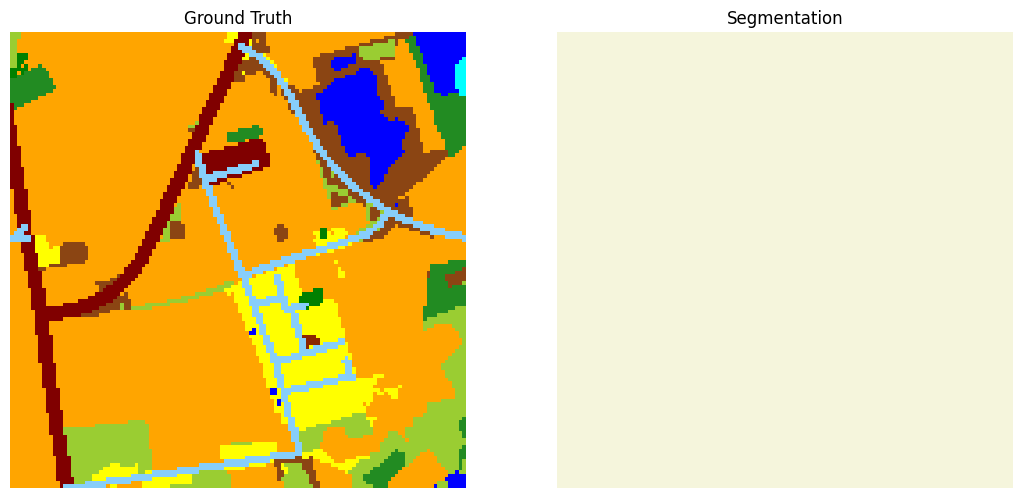

In [16]:

predict_and_show(model_resnet_50, index)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def show_mask(mask):
  # Assuming you have your mask data in a NumPy array named "mask"
  # It should be a 128x128 image containing label values from 0 to 13.

  # Create a custom colormap using the colors defined above
  cmap = ListedColormap(label_map / 255.0)

  # Display the mask using the custom colormap
  plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)

  # Set the number of unique labels for the colorbar
  num_labels = len(label_map)

  # Set the tick positions and labels for the colorbar
  ticks = np.arange(num_labels)

  # Create the colorbar with the custom labels
  cbar = plt.colorbar(ticks=ticks)
  cbar.ax.set_yticklabels(labels, fontsize=8)
  plt.axis("off")
  # Show the plot
  plt.show()

# 4. Training Model

## 4.1 Creating DataLoaders

In [18]:
def calculate_accuracy(pred, target):
    _, predicted = torch.max(pred, 1)
    correct_pixels = (predicted == target).sum().item()
    total_pixels = target.numel()
    accuracy = correct_pixels / total_pixels * 100
    return accuracy

In [19]:
def calculate_f1(pred, target, num_classes):
    f1_list = []
    for class_id in range(num_classes):
        pred_mask = (pred == class_id)
        target_mask = (target == class_id)
        true_positive = (pred_mask & target_mask).sum().item()
        false_positive = (pred_mask & ~target_mask).sum().item()
        false_negative = (~pred_mask & target_mask).sum().item()
        precision = true_positive / (true_positive + false_positive + 1e-8)
        recall = true_positive / (true_positive + false_negative + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)  # Add a small epsilon to avoid division by zero
        f1_list.append(f1)
    return sum(f1_list) / len(f1_list)

In [20]:
def calculate_iou(pred, target, num_classes):
    iou_list = []
    for class_id in range(num_classes):
        pred_mask = (pred == class_id)
        target_mask = (target == class_id)
        intersection = (pred_mask & target_mask).sum().item()
        union = (pred_mask | target_mask).sum().item()
        iou = intersection / (union + 1e-8)  # Add a small epsilon to avoid division by zero
        iou_list.append(iou)
    return sum(iou_list) / len(iou_list)

In [21]:
import torch
from skimage.io import imread
from torch.utils import data
from utils import get_img

class SegmentationDataSet(data.Dataset):
    def __init__(self,
                 file_path='/content/data/C2Seg_AB/train',
                 transform=None
                 ):
        self.file_path = file_path
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.float32
        self.transform = transform

    def __len__(self):
        return 272

    def __getitem__(self,
                    index: int):
        # Select the sample
        X, y = get_img(index, self.file_path)
        X = torch.squeeze(X)
        # Preprocessing
        if self.transform is not None:
            X, y = self.transform(X, y)

        # Typecasting
        X, y = X.type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return X, y

In [22]:
training_dataset = SegmentationDataSet()

training_dataloader = data.DataLoader(dataset=training_dataset,
                                      batch_size=8,
                                      shuffle=True)
x, y = next(iter(training_dataloader))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([8, 26, 128, 128]); type: torch.float32
x = min: -95014.4296875; max: 23708.009765625
y = shape: torch.Size([8, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


## 4.2 Training Loop

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train(model, data_loader, loss_fn, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        start_time = time.time()
        print("")
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        running_iou = 0.0
        running_f1 = 0.0

        loss_epoch = []
        acc_epoch = []
        iou_epoch = []
        f1_epoch = []

        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            accuracy = calculate_accuracy(outputs["out"], targets)
            iou = calculate_iou(torch.argmax(outputs["out"], dim=1), targets, 14)
            f1 = calculate_f1(torch.argmax(outputs["out"], dim=1), targets, num_classes=14)

            # Calculate the loss
            loss = loss_fn(outputs["out"], targets.long())  # Assuming targets are integer class labels
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += accuracy
            running_iou += iou
            running_f1 = f1

            if batch_idx % 10 == 9:  # Print every 10 mini-batches
                mean_loss = running_loss / 10
                mean_acc = running_acc / 10
                mean_iou = running_iou / 10
                mean_f1 = running_f1 / 10

                #print(f"Epoch {epoch + 1} | Batch {batch_idx + 1}/{len(data_loader)} | Loss: {mean_loss:.4f} | Accuracy: {mean_acc:.4f}% | IOU: {mean_iou:.4f} | F1: {mean_f1:.4f}")
                running_loss = 0.0
                running_acc = 0.0
                running_iou = 0.0
                running_f1 = 0.0

                loss_epoch.append(mean_loss)
                acc_epoch.append(mean_acc)
                iou_epoch.append(mean_iou)
                f1_epoch.append(mean_f1)

        epoch_duration = time.time() - start_time
        print(f"Epoch {epoch + 1} | Time: {epoch_duration:.2f}s | Mean Loss: {(sum(loss_epoch) / len(loss_epoch)):.4f} | Mean Accuracy: {(sum(acc_epoch) / len(acc_epoch)):.4f}% | mIOU: {(sum(iou_epoch) / len(iou_epoch)):.4f} | mF1: {(sum(f1_epoch) / len(f1_epoch)):.4f}")
# Set the number of training epochs

# Assuming you have your model, optimizer, and data loader ready, start the training:
# train(model, training_dataloader, loss_fn, optimizer, num_epochs)

In [ ]:
# Define your optimizer (e.g., Adam)
optimizer = optim.Adam(model_resnet_50.parameters(), lr=0.001)

# Define the loss function (CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 16

train(model_resnet_50, training_dataloader, loss_fn, optimizer, num_epochs)



Epoch 1 | Time: 60.74s | Mean Loss: 2.2468 | Mean Accuracy: 22.9456% | mIOU: 0.0295 | mF1: 0.0045


Epoch 2 | Time: 56.70s | Mean Loss: 2.0401 | Mean Accuracy: 29.1437% | mIOU: 0.0394 | mF1: 0.0065


Epoch 3 | Time: 62.60s | Mean Loss: 1.9883 | Mean Accuracy: 31.5809% | mIOU: 0.0422 | mF1: 0.0069


Epoch 4 | Time: 57.22s | Mean Loss: 1.9467 | Mean Accuracy: 33.0584% | mIOU: 0.0480 | mF1: 0.0080


Epoch 5 | Time: 53.75s | Mean Loss: 1.9756 | Mean Accuracy: 30.7256% | mIOU: 0.0466 | mF1: 0.0071


Epoch 6 | Time: 53.93s | Mean Loss: 1.9191 | Mean Accuracy: 34.8842% | mIOU: 0.0538 | mF1: 0.0091


Epoch 7 | Time: 53.40s | Mean Loss: 1.9127 | Mean Accuracy: 34.1523% | mIOU: 0.0541 | mF1: 0.0092


Epoch 8 | Time: 54.98s | Mean Loss: 1.8865 | Mean Accuracy: 36.3057% | mIOU: 0.0591 | mF1: 0.0088


Epoch 9 | Time: 52.90s | Mean Loss: 1.8748 | Mean Accuracy: 37.2434% | mIOU: 0.0609 | mF1: 0.0104


Epoch 10 | Time: 52.87s | Mean Loss: 1.8610 | Mean Accuracy: 36.8655% | mIOU: 0.0599 | mF1: 0.0096

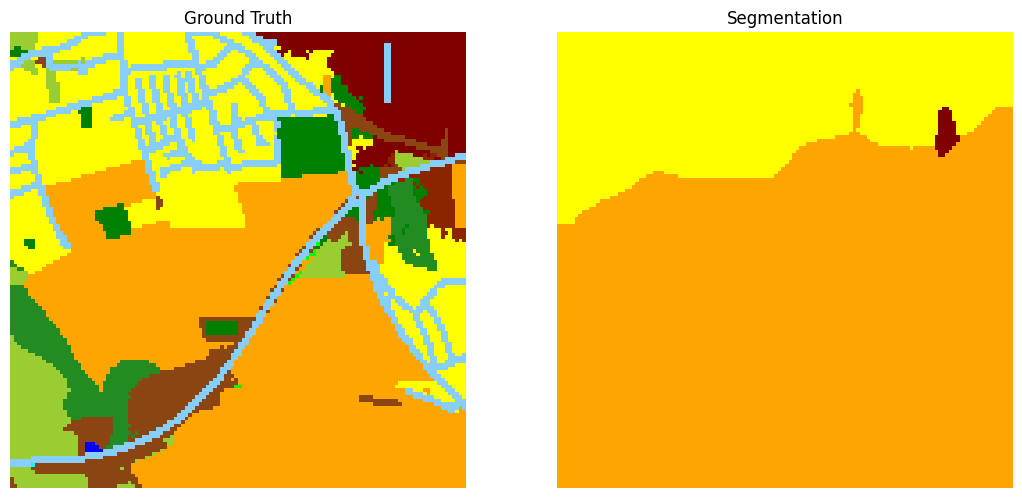

In [ ]:
predict_and_show(model_resnet_50, 242)

In [ ]:
optimizer = optim.Adam(model_resnet_50.parameters(), lr=0.001)
num_epochs=20
train(model_resnet_50, training_dataloader, loss_fn, optimizer, num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [01:05<20:53, 65.96s/it]


-----
Epoch 1 | Mean Loss: 1.6760 | Mean Accuracy: 44.7172% | mIOU: 0.1006 | mF1: 0.0153
-----



 10%|█         | 2/20 [02:10<19:27, 64.84s/it]


-----
Epoch 2 | Mean Loss: 1.6264 | Mean Accuracy: 47.6784% | mIOU: 0.1106 | mF1: 0.0159
-----



 15%|█▌        | 3/20 [03:16<18:33, 65.48s/it]


-----
Epoch 3 | Mean Loss: 1.6636 | Mean Accuracy: 44.9923% | mIOU: 0.0984 | mF1: 0.0142
-----



 20%|██        | 4/20 [04:21<17:25, 65.35s/it]


-----
Epoch 4 | Mean Loss: 1.6417 | Mean Accuracy: 45.7639% | mIOU: 0.1019 | mF1: 0.0154
-----



 25%|██▌       | 5/20 [05:26<16:16, 65.09s/it]


-----
Epoch 5 | Mean Loss: 1.6579 | Mean Accuracy: 45.3130% | mIOU: 0.1035 | mF1: 0.0138
-----



 30%|███       | 6/20 [06:29<15:04, 64.63s/it]


-----
Epoch 6 | Mean Loss: 1.6487 | Mean Accuracy: 45.9840% | mIOU: 0.1058 | mF1: 0.0149
-----



 35%|███▌      | 7/20 [07:33<13:56, 64.32s/it]


-----
Epoch 7 | Mean Loss: 1.6442 | Mean Accuracy: 46.2198% | mIOU: 0.1039 | mF1: 0.0148
-----



 40%|████      | 8/20 [08:37<12:49, 64.10s/it]


-----
Epoch 8 | Mean Loss: 1.6612 | Mean Accuracy: 45.6316% | mIOU: 0.1048 | mF1: 0.0143
-----



 45%|████▌     | 9/20 [09:41<11:45, 64.13s/it]


-----
Epoch 9 | Mean Loss: 1.6332 | Mean Accuracy: 46.6368% | mIOU: 0.1050 | mF1: 0.0136
-----



 50%|█████     | 10/20 [10:45<10:40, 64.09s/it]


-----
Epoch 10 | Mean Loss: 1.6410 | Mean Accuracy: 46.5446% | mIOU: 0.1059 | mF1: 0.0135
-----



 55%|█████▌    | 11/20 [11:49<09:36, 64.06s/it]


-----
Epoch 11 | Mean Loss: 1.6550 | Mean Accuracy: 45.6876% | mIOU: 0.1007 | mF1: 0.0146
-----



 60%|██████    | 12/20 [12:53<08:31, 63.95s/it]


-----
Epoch 12 | Mean Loss: 1.6600 | Mean Accuracy: 45.6538% | mIOU: 0.1010 | mF1: 0.0125
-----



 65%|██████▌   | 13/20 [13:57<07:28, 64.06s/it]


-----
Epoch 13 | Mean Loss: 1.6585 | Mean Accuracy: 45.3598% | mIOU: 0.0997 | mF1: 0.0140
-----



 70%|███████   | 14/20 [15:01<06:24, 64.08s/it]


-----
Epoch 14 | Mean Loss: 1.6373 | Mean Accuracy: 45.8729% | mIOU: 0.1035 | mF1: 0.0169
-----



 75%|███████▌  | 15/20 [16:04<05:19, 63.88s/it]


-----
Epoch 15 | Mean Loss: 1.6397 | Mean Accuracy: 45.8150% | mIOU: 0.1076 | mF1: 0.0160
-----



 80%|████████  | 16/20 [17:08<04:14, 63.69s/it]


-----
Epoch 16 | Mean Loss: 1.6577 | Mean Accuracy: 45.5186% | mIOU: 0.1014 | mF1: 0.0134
-----



 85%|████████▌ | 17/20 [18:13<03:12, 64.16s/it]


-----
Epoch 17 | Mean Loss: 1.6054 | Mean Accuracy: 47.7993% | mIOU: 0.1148 | mF1: 0.0169
-----



 90%|█████████ | 18/20 [19:17<02:08, 64.26s/it]


-----
Epoch 18 | Mean Loss: 1.6268 | Mean Accuracy: 46.3940% | mIOU: 0.1063 | mF1: 0.0145
-----



 95%|█████████▌| 19/20 [20:22<01:04, 64.27s/it]


-----
Epoch 19 | Mean Loss: 1.6125 | Mean Accuracy: 47.3760% | mIOU: 0.1086 | mF1: 0.0160
-----



100%|██████████| 20/20 [21:26<00:00, 64.34s/it]


-----
Epoch 20 | Mean Loss: 1.6400 | Mean Accuracy: 46.7065% | mIOU: 0.1066 | mF1: 0.0154
-----


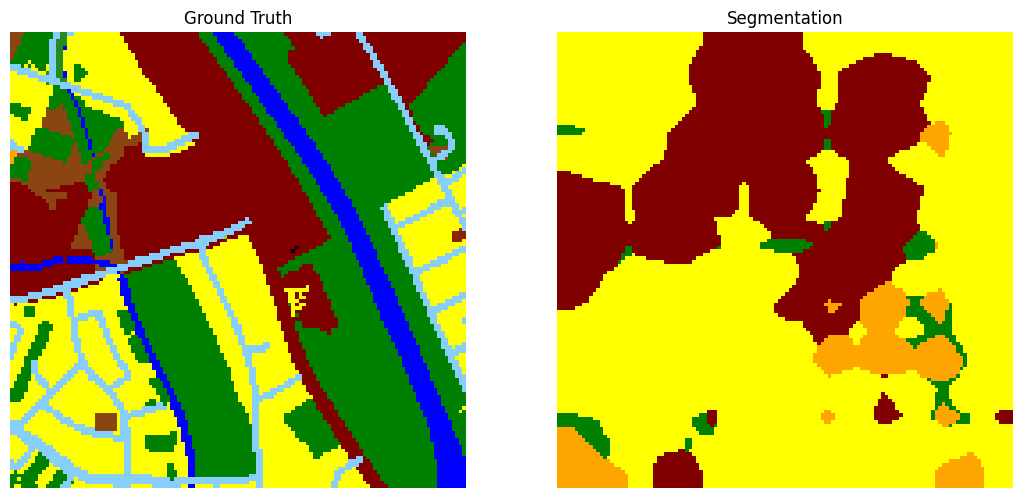

In [ ]:
predict_and_show(model_resnet_50, 19)

#5. Save The Base Model

In [ ]:
torch.save(model_resnet_50, "models/resnet_50_base.pth")

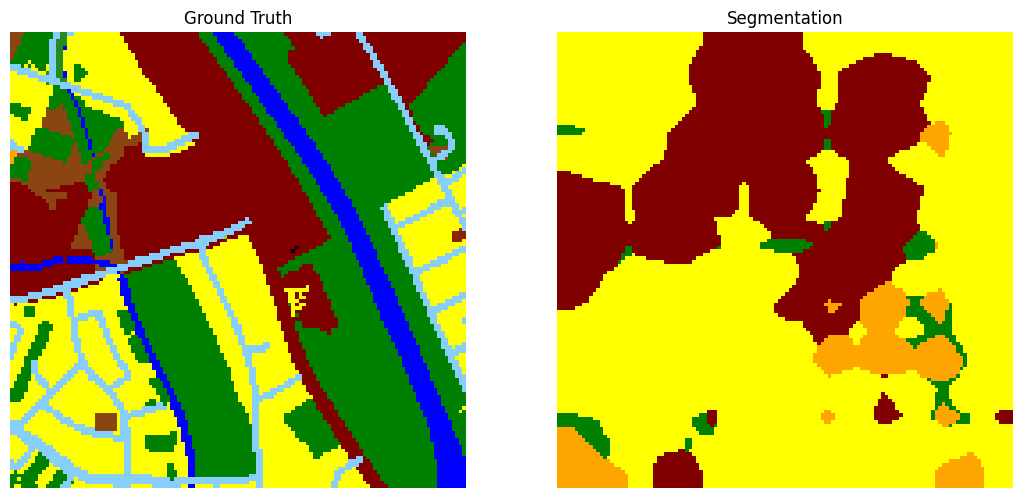

In [ ]:
loaded_model = torch.load("models/resnet_50_base.pth")
predict_and_show(loaded_model, 19)

# 5. Trying another models

## 5.1 ResNet50 with 248 channels

In [46]:
model_resnet_50_2, transforms = get_model('resnet_50', 248, 14)

In [47]:
import torch
from skimage.io import imread
from torch.utils import data
from utils import get_img

class SegmentationDataSet2(data.Dataset):
    def __init__(self,
                 file_path='/content/data/C2Seg_AB/train',
                 transform=None
                 ):
        self.file_path = file_path
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.float32
        self.transform = transform

    def __len__(self):
        return 272

    def __getitem__(self,
                    index: int):
        # Select the sample
        X, y = get_img(index, self.file_path, reduce_hsi=False)
        X = torch.squeeze(X)
        # Preprocessing
        if self.transform is not None:
            X, y = self.transform(X, y)

        # Typecasting
        X, y = X.type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return X, y

In [50]:
training_dataset2 = SegmentationDataSet2()

training_dataloader2 = data.DataLoader(dataset=training_dataset2,
                                      batch_size=8,
                                      shuffle=True)
x, y = next(iter(training_dataloader2))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([8, 248, 128, 128]); type: torch.float32
x = min: -31.3063907623291; max: 13084.0
y = shape: torch.Size([8, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]); type: torch.float32


In [59]:
# Define your optimizer (e.g., Adam)
optimizer = optim.Adam(model_resnet_50_2.parameters(), lr=0.001)

# Define the loss function (CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50

train(model_resnet_50_2, training_dataloader2, loss_fn, optimizer, num_epochs)


Epoch 1 | Time: 19.42s | Mean Loss: 1.7237 | Mean Accuracy: 41.9419% | mIOU: 0.0958 | mF1: 0.0146

Epoch 2 | Time: 18.47s | Mean Loss: 1.6981 | Mean Accuracy: 43.3833% | mIOU: 0.0971 | mF1: 0.0155

Epoch 3 | Time: 19.27s | Mean Loss: 1.7004 | Mean Accuracy: 43.0453% | mIOU: 0.0993 | mF1: 0.0137

Epoch 4 | Time: 18.46s | Mean Loss: 1.6741 | Mean Accuracy: 43.9094% | mIOU: 0.1028 | mF1: 0.0155

Epoch 5 | Time: 19.14s | Mean Loss: 1.6980 | Mean Accuracy: 43.3695% | mIOU: 0.1012 | mF1: 0.0159

Epoch 6 | Time: 19.28s | Mean Loss: 1.6675 | Mean Accuracy: 45.1412% | mIOU: 0.1044 | mF1: 0.0136

Epoch 7 | Time: 19.08s | Mean Loss: 1.6630 | Mean Accuracy: 45.3024% | mIOU: 0.1059 | mF1: 0.0153

Epoch 8 | Time: 19.21s | Mean Loss: 1.7037 | Mean Accuracy: 43.0388% | mIOU: 0.0961 | mF1: 0.0152

Epoch 9 | Time: 18.53s | Mean Loss: 1.6535 | Mean Accuracy: 45.9512% | mIOU: 0.1081 | mF1: 0.0149

Epoch 10 | Time: 19.24s | Mean Loss: 1.6493 | Mean Accuracy: 45.0193% | mIOU: 0.1066 | mF1: 0.0164

Epoch 11

In [83]:
import random

from utils import get_img

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def predict_and_show2(model, indices=None):
    if indices is None:
        indices = random.sample(range(1, 273), 6)  # Change max_index to the maximum index available in your dataset

    plt.figure(figsize=(20, 20))

    for idx, index in enumerate(indices, 1):
        X, mask = get_img(index, reduce_hsi=False)
        X = X.to(device)
        model.eval()
        with torch.inference_mode():
            output = model(X)["out"].to(device)

        W, H = output.shape[2], output.shape[3]

        # Get RGB segmentation map
        segmented_image = draw_segmentation_map(output)

        # Resize to original image size
        segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)

        plt.subplot(6, 3, 3 * (idx - 1) + 1)
        cmap = ListedColormap(label_map / 255.0)
        plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)
        plt.title(f"Ground Truth - Image {index}")
        plt.axis("off")

        plt.subplot(6, 3, 3 * (idx - 1) + 2)
        plt.title(f"Segmentation - Image {index}")
        plt.axis("off")
        plt.imshow(segmented_image)

    plt.tight_layout()
    plt.show()
    plt.close()


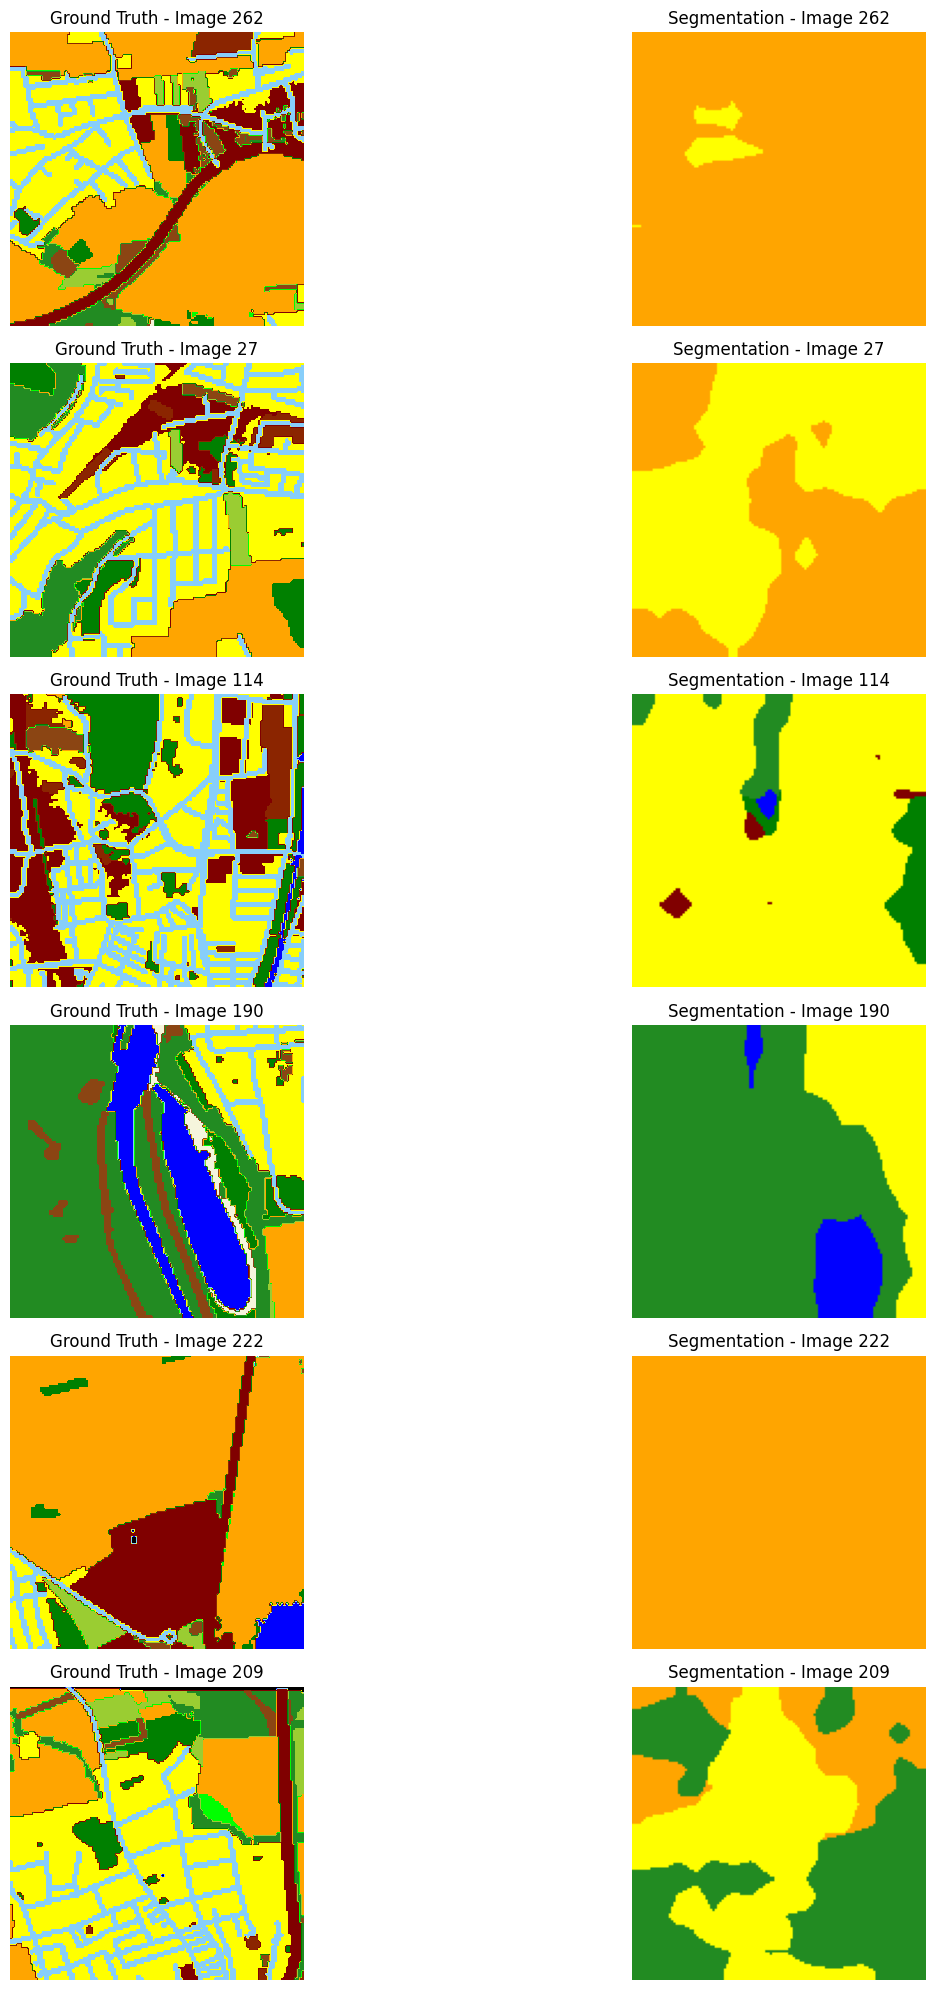

In [89]:
predict_and_show2(model_resnet_50_2)

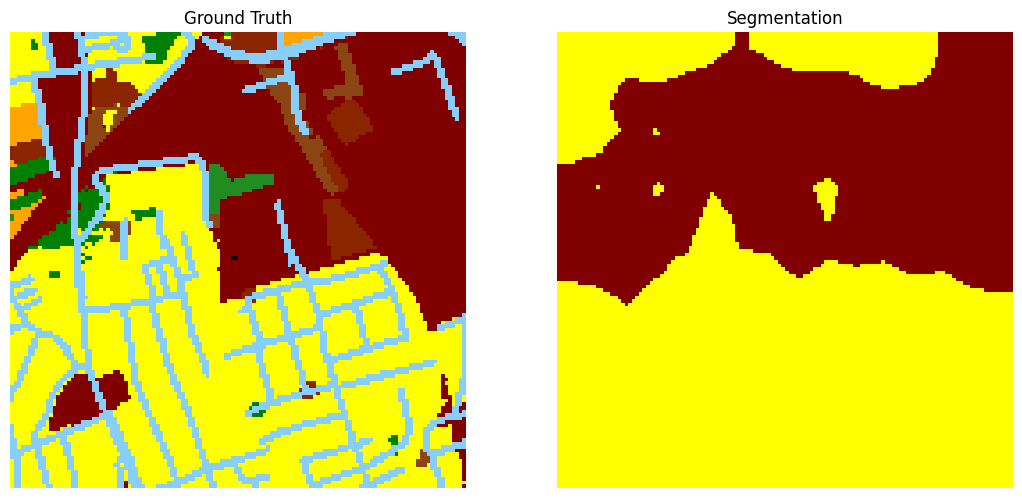

In [71]:
torch.save(model_resnet_50_2, "models/resnet_50_248_bands.pth")
loaded_model = torch.load("models/resnet_50_248_bands.pth")
predict_and_show2(loaded_model, 12)

## 5.2 Resnet50 without hsi

In [30]:
model_resnet_50_3, transforms = get_model('resnet_50', 6, 14)

In [31]:
import torch
from skimage.io import imread
from torch.utils import data
from utils import get_img

class SegmentationDataSet3(data.Dataset):
    def __init__(self,
                 file_path='/content/data/C2Seg_AB/train',
                 transform=None
                 ):
        self.file_path = file_path
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.float32
        self.transform = transform

    def __len__(self):
        return 272

    def __getitem__(self,
                    index: int):
        # Select the sample
        X, y = get_img(index, self.file_path, reduce_hsi=False, use_hsi=False)
        X = torch.squeeze(X)
        # Preprocessing
        if self.transform is not None:
            X, y = self.transform(X, y)

        # Typecasting
        X, y = X.type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return X, y

In [46]:
training_dataset3 = SegmentationDataSet3()

training_dataloader3 = data.DataLoader(dataset=training_dataset3,
                                      batch_size=16,
                                      shuffle=True)
x, y = next(iter(training_dataloader3))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([16, 6, 128, 128]); type: torch.float32
x = min: -29.957836151123047; max: 5353.0
y = shape: torch.Size([16, 128, 128]); class: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]); type: torch.float32


In [34]:
# Define your optimizer (e.g., Adam)
optimizer = optim.Adam(model_resnet_50_3.parameters(), lr=0.001)

# Define the loss function (CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50

train(model_resnet_50_3, training_dataloader3, loss_fn, optimizer, num_epochs)


Epoch 1 | Time: 4.97s | Mean Loss: 1.8712 | Mean Accuracy: 35.9728% | mIOU: 0.0596 | mF1: 0.0084

Epoch 2 | Time: 4.32s | Mean Loss: 1.8077 | Mean Accuracy: 39.1825% | mIOU: 0.0741 | mF1: 0.0103

Epoch 3 | Time: 4.40s | Mean Loss: 1.8218 | Mean Accuracy: 37.3004% | mIOU: 0.0709 | mF1: 0.0108

Epoch 4 | Time: 4.38s | Mean Loss: 1.7966 | Mean Accuracy: 38.8712% | mIOU: 0.0782 | mF1: 0.0108

Epoch 5 | Time: 4.45s | Mean Loss: 1.7713 | Mean Accuracy: 39.8608% | mIOU: 0.0809 | mF1: 0.0113

Epoch 6 | Time: 4.46s | Mean Loss: 1.7501 | Mean Accuracy: 40.1420% | mIOU: 0.0819 | mF1: 0.0133

Epoch 7 | Time: 4.45s | Mean Loss: 1.7775 | Mean Accuracy: 39.7379% | mIOU: 0.0806 | mF1: 0.0117

Epoch 8 | Time: 4.55s | Mean Loss: 1.7395 | Mean Accuracy: 40.9378% | mIOU: 0.0874 | mF1: 0.0105

Epoch 9 | Time: 4.51s | Mean Loss: 1.7481 | Mean Accuracy: 40.3764% | mIOU: 0.0845 | mF1: 0.0124

Epoch 10 | Time: 4.52s | Mean Loss: 1.7243 | Mean Accuracy: 41.6857% | mIOU: 0.0890 | mF1: 0.0140

Epoch 11 | Time: 4

In [48]:
# Define your optimizer (e.g., Adam)
optimizer = optim.Adam(model_resnet_50_3.parameters(), lr=0.001)

# Define the loss function (CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 100

train(model_resnet_50_3, training_dataloader3, loss_fn, optimizer, num_epochs)


Epoch 1 | Time: 4.39s | Mean Loss: 1.5614 | Mean Accuracy: 47.9491% | mIOU: 0.1341 | mF1: 0.0180

Epoch 2 | Time: 4.11s | Mean Loss: 1.5410 | Mean Accuracy: 48.5590% | mIOU: 0.1391 | mF1: 0.0186

Epoch 3 | Time: 4.13s | Mean Loss: 1.5596 | Mean Accuracy: 47.5178% | mIOU: 0.1326 | mF1: 0.0185

Epoch 4 | Time: 4.21s | Mean Loss: 1.5527 | Mean Accuracy: 48.1221% | mIOU: 0.1331 | mF1: 0.0217

Epoch 5 | Time: 4.19s | Mean Loss: 1.5562 | Mean Accuracy: 48.0158% | mIOU: 0.1417 | mF1: 0.0191

Epoch 6 | Time: 4.22s | Mean Loss: 1.5019 | Mean Accuracy: 50.3591% | mIOU: 0.1393 | mF1: 0.0181

Epoch 7 | Time: 4.31s | Mean Loss: 1.4783 | Mean Accuracy: 51.3890% | mIOU: 0.1503 | mF1: 0.0213

Epoch 8 | Time: 4.28s | Mean Loss: 1.5166 | Mean Accuracy: 49.1109% | mIOU: 0.1396 | mF1: 0.0204

Epoch 9 | Time: 4.28s | Mean Loss: 1.5111 | Mean Accuracy: 50.1042% | mIOU: 0.1478 | mF1: 0.0234

Epoch 10 | Time: 4.32s | Mean Loss: 1.5488 | Mean Accuracy: 47.4492% | mIOU: 0.1326 | mF1: 0.0180

Epoch 11 | Time: 4

In [36]:
import random

from utils import get_img

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def predict_and_show3(model, indices=None):
    if indices is None:
        indices = random.sample(range(1, 273), 6)  # Change max_index to the maximum index available in your dataset

    plt.figure(figsize=(20, 20))

    for idx, index in enumerate(indices, 1):
        X, mask = get_img(index, reduce_hsi=False, use_hsi=False)
        X = X.to(device)
        model.eval()
        with torch.inference_mode():
            output = model(X)["out"].to(device)

        W, H = output.shape[2], output.shape[3]

        # Get RGB segmentation map
        segmented_image = draw_segmentation_map(output)

        # Resize to original image size
        segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)

        plt.subplot(6, 3, 3 * (idx - 1) + 1)
        cmap = ListedColormap(label_map / 255.0)
        plt.imshow(mask, cmap=cmap, vmin=0, vmax=13)
        plt.title(f"Ground Truth - Image {index}")
        plt.axis("off")

        plt.subplot(6, 3, 3 * (idx - 1) + 2)
        plt.title(f"Segmentation - Image {index}")
        plt.axis("off")
        plt.imshow(segmented_image)

    plt.tight_layout()
    plt.show()
    plt.close()


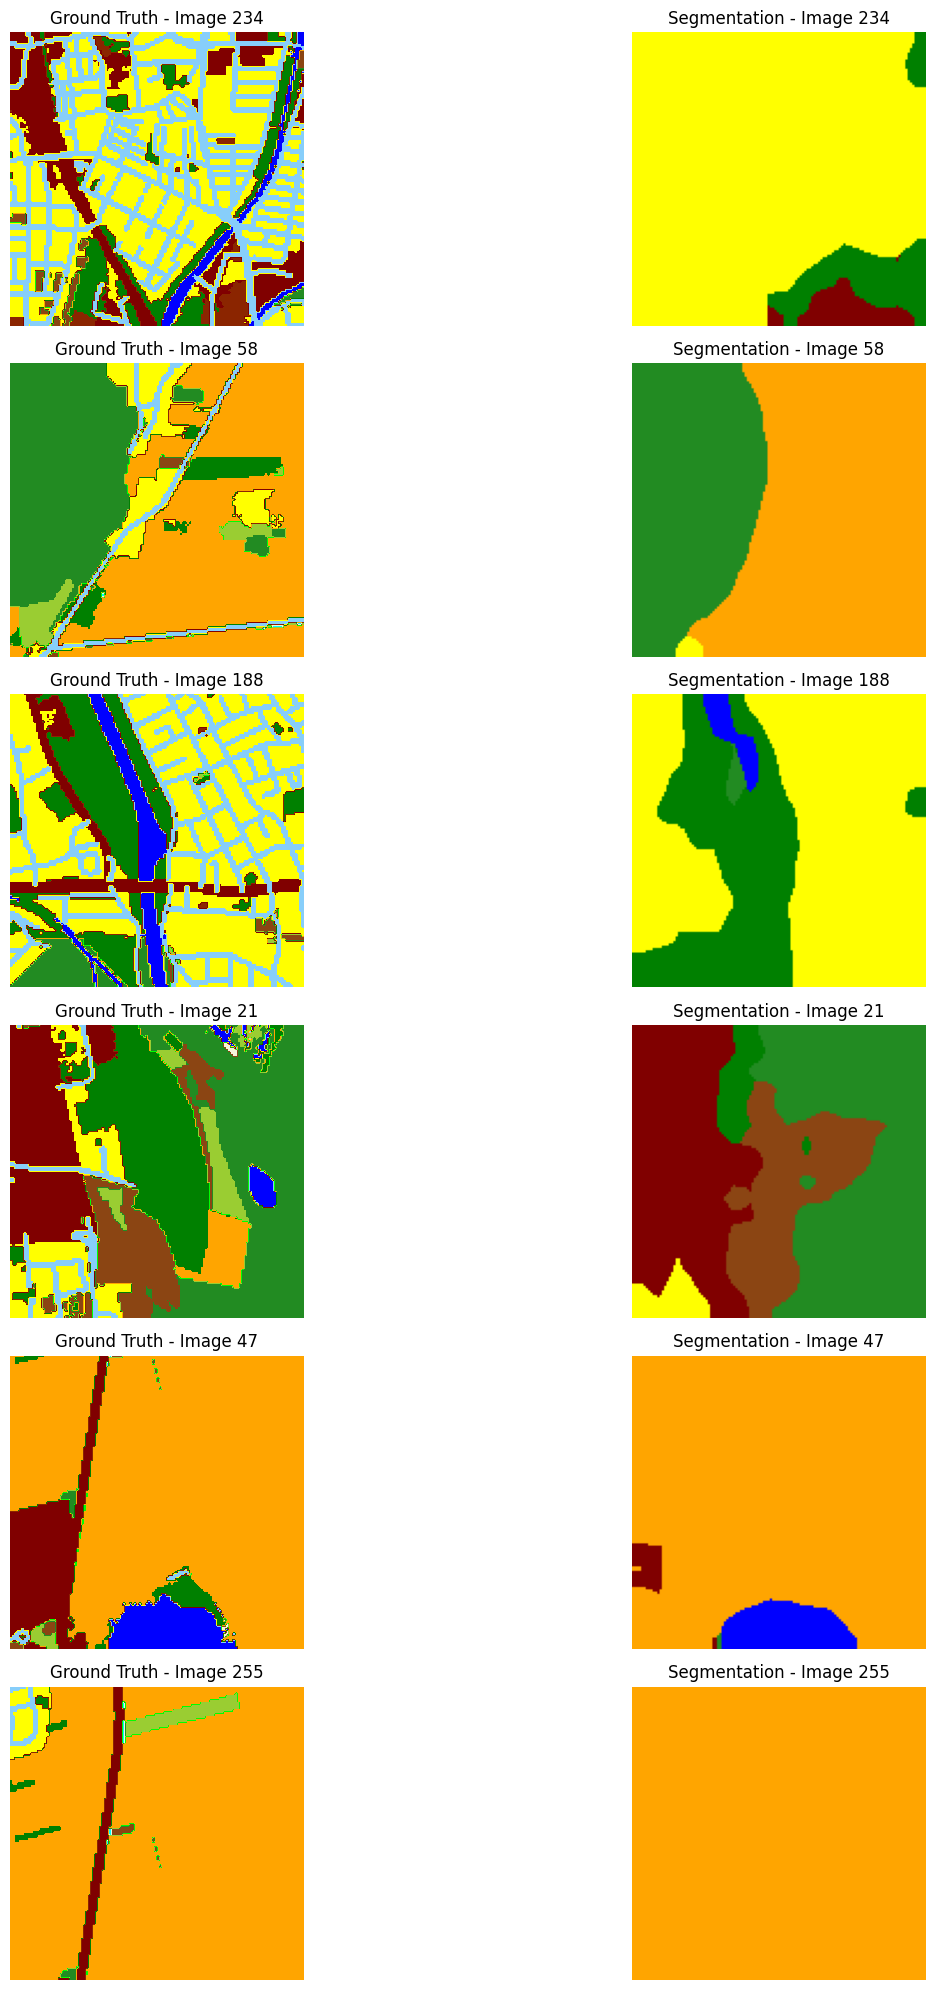

In [51]:
predict_and_show3(model_resnet_50_3)

In [59]:
torch.save(model_resnet_50_3, "models/resnet_50_no_hsi.pth")
loaded_model = torch.load("models/resnet_50_no_hsi.pth")

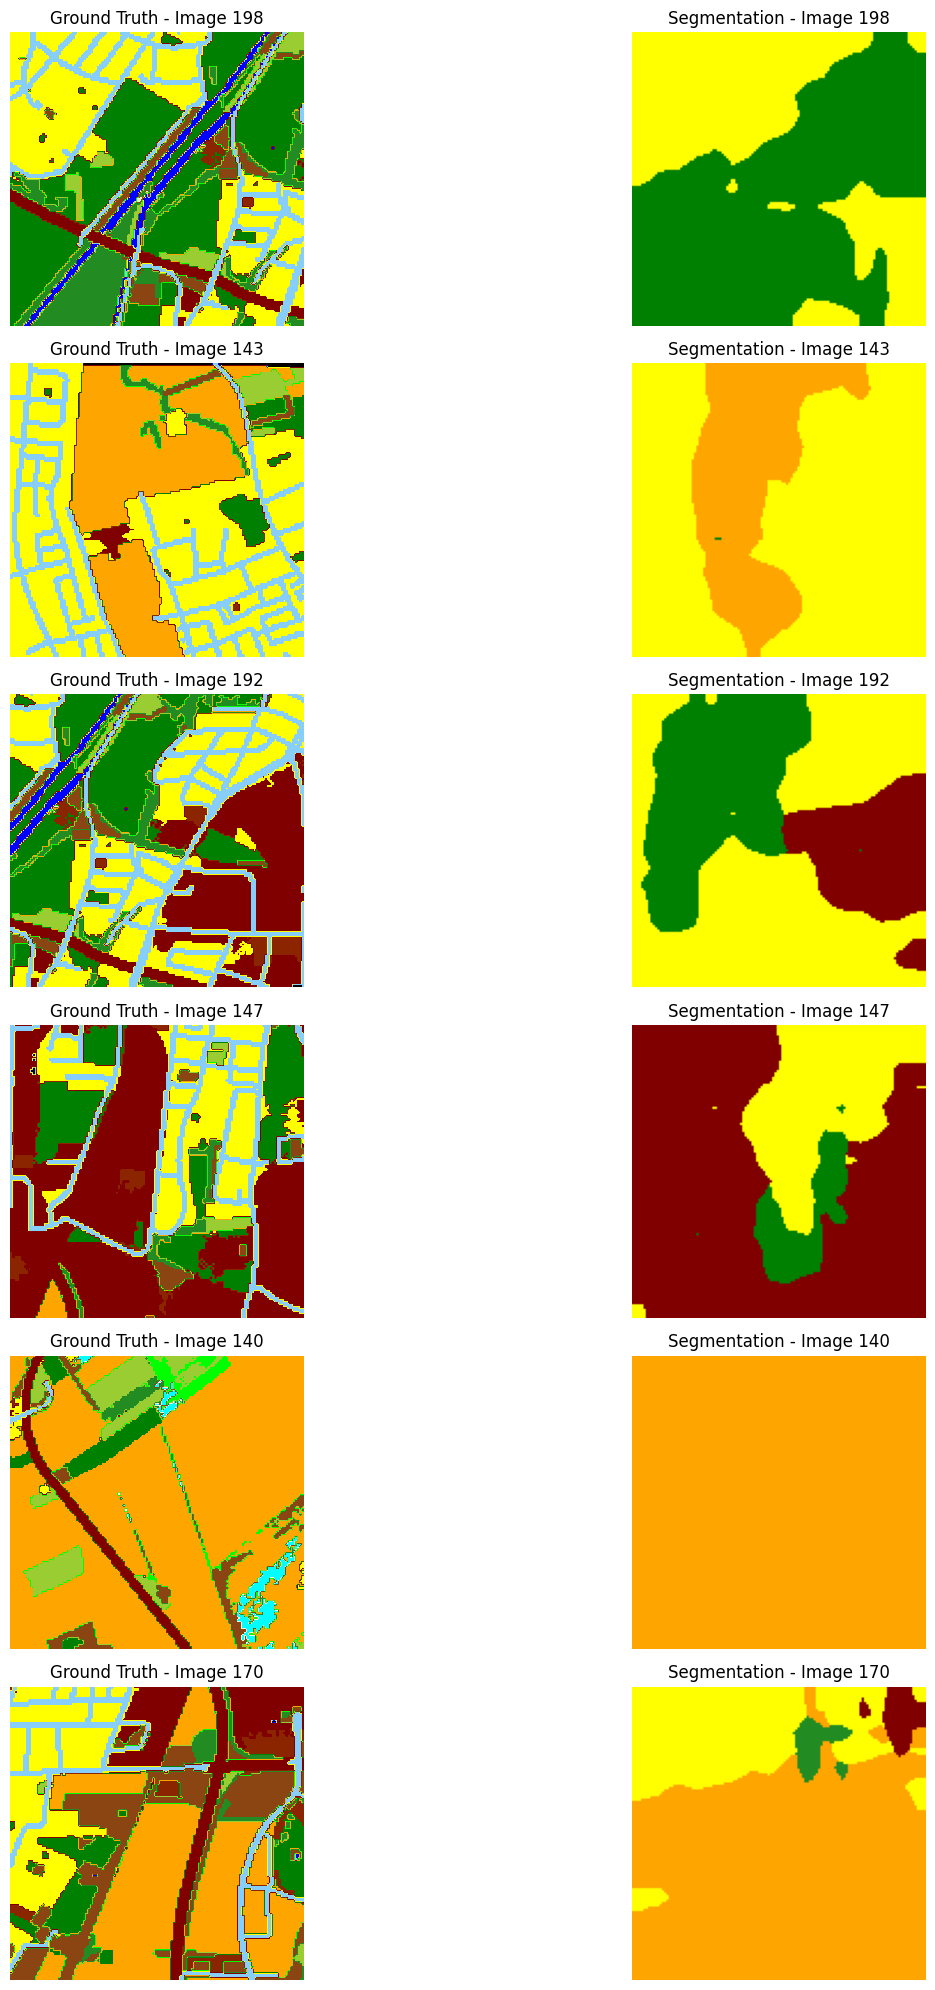

In [61]:
predict_and_show3(loaded_model)